# **Overview of Class Activation Mapping (CAM)**

Class Activation Maps (CAM) provide a way to identify **which regions of an input image contribute most** to a convolutional neural network’s decision for a specific class. CAMs highlight the spatial locations in the feature maps that are most influential for predicting class $c$, allowing an interpretable visualization of the model’s attention.

### **Concept**

In many CNN architectures with **global average pooling (GAP)** before the final classification layer, each feature map $f_k(x, y)$ (the activation of channel $k$ at spatial location $(x,y)$) contributes to a class prediction through a learned weight $w^c_k$, which corresponds to how relevant that feature channel is for class $c$.

After GAP, the feature map $f_k(x,y)$ is aggregated into a single scalar:

$$
F_k = \sum_{x,y} f_k(x, y)
$$

The class score for class $c$ is then:

$$
S_c = \sum_{k} w^c_k F_k
= \sum_{k} w^c_k \sum_{x,y} f_k(x,y)
$$

This can be rearranged as:

$$
S_c = \sum_{x,y} \sum_{k} w^c_k f_k(x,y)
$$

### **Class Activation Map**

CAM defines a spatial map $M_c(x,y)$ that represents how much each location contributes to class $c$:

$$
M_c(x, y) = \sum_{k} w^c_k , f_k(x, y)
$$

This score is directly related to the class prediction:

$$
S_c = \sum_{x,y} M_c(x,y)
$$

Thus, the CAM $M_c(x,y)$ can be **upsampled and overlaid on the original image**, showing the regions that the model finds most important for identifying class (c).

### **Interpretation**

- High values of $M_c(x,y)$ indicate strong influence on predicting class $c$.
- CAM highlights local discriminative regions without requiring backpropagation.
- It is particularly useful for visual explanation and model interpretability.

# **Inputs**

In [1]:
import numpy as np
import cv2
import requests
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn.functional as F
import torch

# **Load ResNet18 Model**

In [2]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model = model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


# **Define Hook To Capture Feature Maps**

In [3]:
activation = {}
def getActivation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Attach hook to the last convolutional layer (layer4 in ResNet)
model.layer4.register_forward_hook(getActivation('final_conv'))

# **Load ImageNet Class Labels**

In [4]:
labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_labels = requests.get(labels_url).text.split('\n')

# **Prepare Data**

In [5]:
image_path = "/kaggle/input/sample-images/img1.jpg"  
original_img_cv2 = cv2.imread(image_path)

# Convert BGR to RGB for Matplotlib and ResNet18 to work
original_img_rgb = cv2.cvtColor(original_img_cv2, cv2.COLOR_BGR2RGB)

# Store original dimensions for final resizing
h_orig, w_orig, _ = original_img_rgb.shape

# Define transforms
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Apply transforms and add batch dimension
input_tensor = preprocess(original_img_rgb)
input_batch = input_tensor.unsqueeze(0)

# **Forward Pass**

In [6]:
outputs = model(input_batch)

# Get prediction
probabilities = F.softmax(outputs, dim=1)
class_idx = torch.argmax(probabilities).item()
class_name = imagenet_labels[class_idx]
confidence = probabilities[0][class_idx].item() * 100

# **Generate CAM**

This block extracts the final convolutional feature maps and the fully connected layer weights, then computes a Class Activation Map (CAM) for the predicted class.  
CAM is computed by taking a weighted sum of the feature maps using the class-specific weights from the final FC layer:

$$
M_c(x, y) = \sum_{k} w_k^c \, f_k(x, y)
$$

Steps performed:

- Retrieve the final conv features $f_k(x,y)$
- Retrieve class-specific FC weights $w_k^c$  
- Compute the dot product across channels  
- Reshape into a spatial heatmap  
- Normalize to $[0, 1]$ and convert to 8-bit

In [7]:
# Fetch features and weights
conv_features = activation['final_conv'].cpu().numpy() # Shape: (1, 512, 7, 7)
weight_fc = model.fc.weight.detach().cpu().numpy()     # Shape: (1000, 512)

def generate_cam(feature_conv, weight_fc, class_idx):
    # _ = batch size, nc = number of channels, h=height, w=width
    _, nc, h, w = feature_conv.shape
    
    # Calculate dot product: (weights for class) * (feature map)
    # We perform a weighted sum of the 512 feature planes
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    
    # Normalize between 0 and 1
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    
    # Convert to uint8 (0-255)
    return np.uint8(255 * cam)

cam_gray = generate_cam(conv_features, weight_fc, class_idx)

# **Visualization**

Predicted Class Index: 207
Predicted Class Name: golden retriever
Confidence: 69.48%


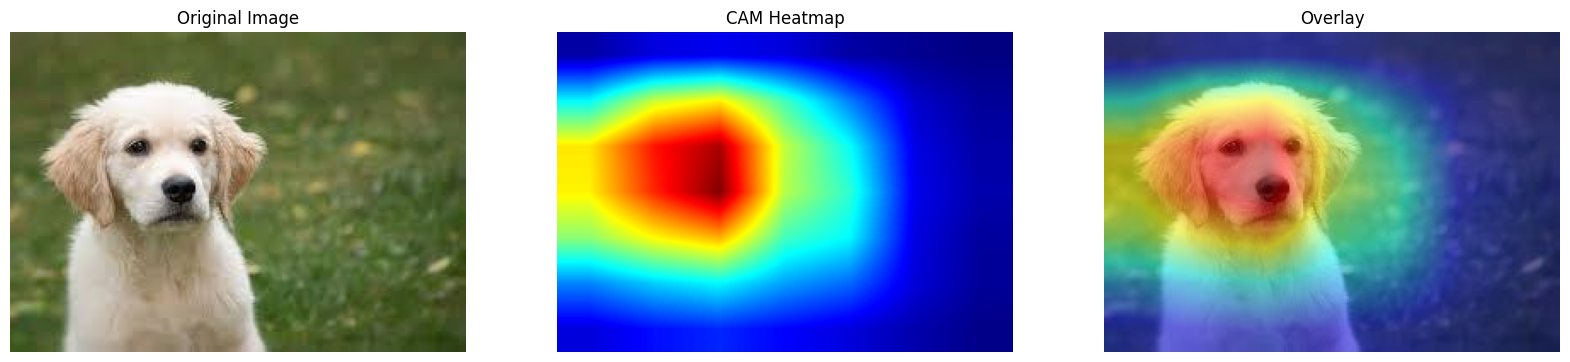

In [8]:
def show_cam_sequence(cam_gray, original_img_rgb):
    h, w, _ = original_img_rgb.shape

    # Resize CAM to match original image size
    cam_resized = cv2.resize(cam_gray, (w, h))

    # Create Heatmap
    heatmap = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) 

    # Create Overlay (Weighted sum) = 0.5 * Heatmap + 0.5 * Original
    overlay = cv2.addWeighted(heatmap, 0.5, original_img_rgb, 0.5, 0)

    # Plotting
    plt.figure(figsize=(20, 9))

    # Plot 1: Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_img_rgb)
    plt.title("Original Image")
    plt.axis("off")

    # Plot 2: Heatmap Only
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title("CAM Heatmap")
    plt.axis("off")

    # Plot 3: Overlay, overlapping the original image and the heatmap
    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title(f"Overlay")
    plt.axis("off")

    plt.show()


print(f"Predicted Class Index: {class_idx}")
print(f"Predicted Class Name: {class_name}")
print(f"Confidence: {confidence:.2f}%")
show_cam_sequence(cam_gray, original_img_rgb)